In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import albumentations as A

In [4]:
# Custom wrapper for albumentations transforms
import numpy as np
from PIL import Image

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        # Apply albumentations transform with named argument
        augmented = self.transform(image=img)
        return augmented['image']

In [5]:
data_dir = '/content/drive/MyDrive/Deep Learning DataSet'

# Load the dataset WITHOUT transforms first
# We will apply specific transforms to train/val/test splits later
full_dataset = ImageFolder(root=data_dir, transform=None)

# Calculate split sizes
train_size = int(0.8 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))
val_size = len(full_dataset) - train_size - test_size

In [6]:
#Get class names and number of classes
class_names = full_dataset.classes
num_classes = len(class_names)
print(f'Classes: {class_names}')
print(f'Number of classes: {num_classes}')

Classes: ['Lab', 'Tree', 'building', 'car', 'person']
Number of classes: 5


In [7]:
# Split the dataset into train, test, and validation sets using STRATIFIED split
# This ensures that each set has the same percentage of each class
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

# Get the targets (labels) for stratification
targets = full_dataset.targets# Get the targets (labels) for stratification


# First split: Train (80%) vs Temp (20%)
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# Get labels for the temp set to stratify the second split
temp_targets = [targets[i] for i in temp_idx]

# Second split: Val (50% of Temp -> 10% total) vs Test (50% of Temp -> 10% total)
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    shuffle=True,
    stratify=temp_targets,
    random_state=42
)

# Create the subsets
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 1488
Val size: 186
Test size: 186


In [8]:
# Helper class to apply transforms to subsets
class ApplyTransform(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Define data augmentations
# Added Resize before RandomCrop to ensure we don't crop small parts of large images
train_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    #A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.Blur(blur_limit=3, p=0.2),
    #A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToTensorV2()
]))

val_transform = AlbumentationsTransform(A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.ToTensorV2(),
]))

# Apply transforms using the wrapper class
# This fixes the issue where modifying .dataset.transform affected ALL splits
train_dataset = ApplyTransform(train_dataset, transform=train_transform)
val_dataset = ApplyTransform(val_dataset, transform=val_transform)
test_dataset = ApplyTransform(test_dataset, transform=val_transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

In [10]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


tensor(0)


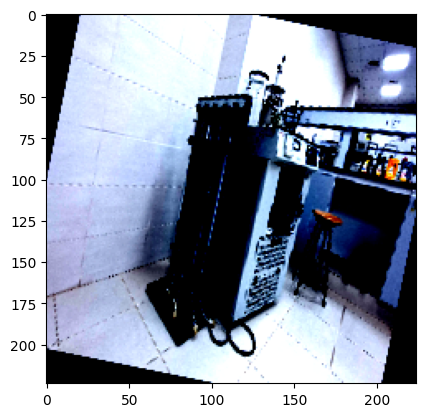

In [11]:
i= 4

image, labels = next(iter(train_loader))
img = image[i]                # [C, H, W]
img = img.permute(1, 2, 0)     # [H, W, C]

print(labels[i])
plt.imshow(img)

In [12]:
#save_image(image[i], "sample_person.png")


In [17]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18, ResNet18_Weights

def make_all_skips_learnable(resnet: nn.Module):
    """
    For every BasicBlock in torchvision ResNet, ensure the skip path is a learned linear map:
    identity(x) becomes downsample(x) = 1x1 conv + BN, even when shapes match.
    """
    for layer_name in ["layer1", "layer2", "layer3", "layer4"]:
        layer = getattr(resnet, layer_name)
        for block in layer:
            # block is torchvision.models.resnet.BasicBlock
            if block.downsample is None:
                in_ch = block.conv1.in_channels
                out_ch = block.conv2.out_channels
                stride = block.conv1.stride[0]  # same stride used by the block

                conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False)
                bn   = nn.BatchNorm2d(out_ch)

                # initialize close to identity when possible
                if in_ch == out_ch and stride == 1:
                    nn.init.dirac_(conv.weight)
                nn.init.ones_(bn.weight)
                nn.init.zeros_(bn.bias)

                block.downsample = nn.Sequential(conv, bn)

    return resnet


class MyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT)

        # make ALL skips learnable (your idea)
        self.model = make_all_skips_learnable(self.model)

        # replace classifier
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


# IMPORTANT: set this from your dataset
# num_classes = len(train_dataset.classes)
model = MyModel(num_classes=num_classes)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 248MB/s]


In [18]:
# Calculate class weights to handle class imbalance
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Get the targets (labels) for stratification

# Extract labels from the train dataset indices
# Access .subset.indices because train_dataset is now an ApplyTransform wrapper
train_labels = [full_dataset.targets[i] for i in train_dataset.subset.indices]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f'Class weights: {class_weights}')

Class weights: tensor([1.7006, 0.7259, 1.1188, 0.7811, 1.1625])


# i was experimenting dynamic batch_size (i forgot to change to the original code)

In [19]:
# freeze all
for p in model.model.parameters():
    p.requires_grad = False

# unfreeze classifier head
for p in model.model.fc.parameters():
    p.requires_grad = True

# unfreeze the learnable skip projections we just added (downsample)
for name, p in model.model.named_parameters():
    if "downsample" in name:
        p.requires_grad = True


In [20]:
#Define optimizer and loss function with learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [21]:
# change the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU compatibility
if torch.cuda.is_available():
	print(f"GPU: {torch.cuda.get_device_name(0)}")
	print(f"CUDA Version: {torch.version.cuda}")
	print(f"PyTorch Version: {torch.__version__}")
	print(f"GPU Compute Capability: {torch.cuda.get_device_capability(0)}")

# Move model to device
model = model.to(device)
criterion = criterion.to(device)

Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6
PyTorch Version: 2.9.0+cu126
GPU Compute Capability: (7, 5)


In [22]:
from torch.utils.data import DataLoader  # (1) add this import if not already

# Check if CUDA is properly configured, otherwise use CPU
try:
    # Test CUDA with a simple operation
    test_tensor = torch.tensor([1.0]).to(device)
    test_result = test_tensor * 2
    print(f"CUDA test passed, using device: {device}")
except RuntimeError as e:
    print(f"CUDA error detected: {e}")
    print("Falling back to CPU")
    device = torch.device("cpu")
    model = model.to(device)
    criterion = criterion.to(device)

# (2) NEW: extract datasets from your existing loaders (fixes val_dataset not defined)
train_dataset = train_loader.dataset
val_dataset   = val_loader.dataset

# (3) NEW: batch schedule function (epoch is 0-based here)
def get_bs(epoch):
    if epoch < 2:      # epochs 1-10
        return 32
    elif epoch < 5:    # epochs 11-20
        return 32
    else:               # epochs 21-30
        return 32

#Training loop with validation, learning rate scheduling, and model saving
num_epochs = 10  # (4) NEW: must be 30 to match your schedule
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(num_epochs):

    # (5) NEW: rebuild train_loader each epoch with the scheduled batch size
    bs = get_bs(epoch)
    train_loader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        num_workers=getattr(train_loader, "num_workers", 0),
        pin_memory=getattr(train_loader, "pin_memory", False),
        drop_last=getattr(train_loader, "drop_last", False),
    )

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    # (6) NEW: print batch size too
    print(f'Epoch {epoch+1}/{num_epochs} | Train BS: {bs}')
    print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('  ✓ Best model saved!')
    print()


CUDA test passed, using device: cuda


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/10 | Train BS: 32
  Train Loss: 0.8036, Train Acc: 70.09%
  Val Loss: 0.3721, Val Acc: 85.48%
  LR: 0.001000
  ✓ Best model saved!

Epoch 2/10 | Train BS: 32
  Train Loss: 0.3350, Train Acc: 88.71%
  Val Loss: 0.2297, Val Acc: 92.47%
  LR: 0.001000
  ✓ Best model saved!

Epoch 3/10 | Train BS: 32
  Train Loss: 0.2148, Train Acc: 92.61%
  Val Loss: 0.2041, Val Acc: 91.40%
  LR: 0.001000

Epoch 4/10 | Train BS: 32
  Train Loss: 0.1695, Train Acc: 94.35%
  Val Loss: 0.1579, Val Acc: 94.09%
  LR: 0.001000
  ✓ Best model saved!

Epoch 5/10 | Train BS: 32
  Train Loss: 0.1201, Train Acc: 96.24%
  Val Loss: 0.2119, Val Acc: 92.47%
  LR: 0.001000

Epoch 6/10 | Train BS: 32
  Train Loss: 0.0928, Train Acc: 96.91%
  Val Loss: 0.1594, Val Acc: 94.09%
  LR: 0.001000

Epoch 7/10 | Train BS: 32
  Train Loss: 0.0840, Train Acc: 97.11%
  Val Loss: 0.1478, Val Acc: 94.62%
  LR: 0.001000
  ✓ Best model saved!

Epoch 8/10 | Train BS: 32
  Train Loss: 0.0686, Train Acc: 97.38%
  Val Loss: 0.0750, 

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

# measure test accuracy
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 95.16%


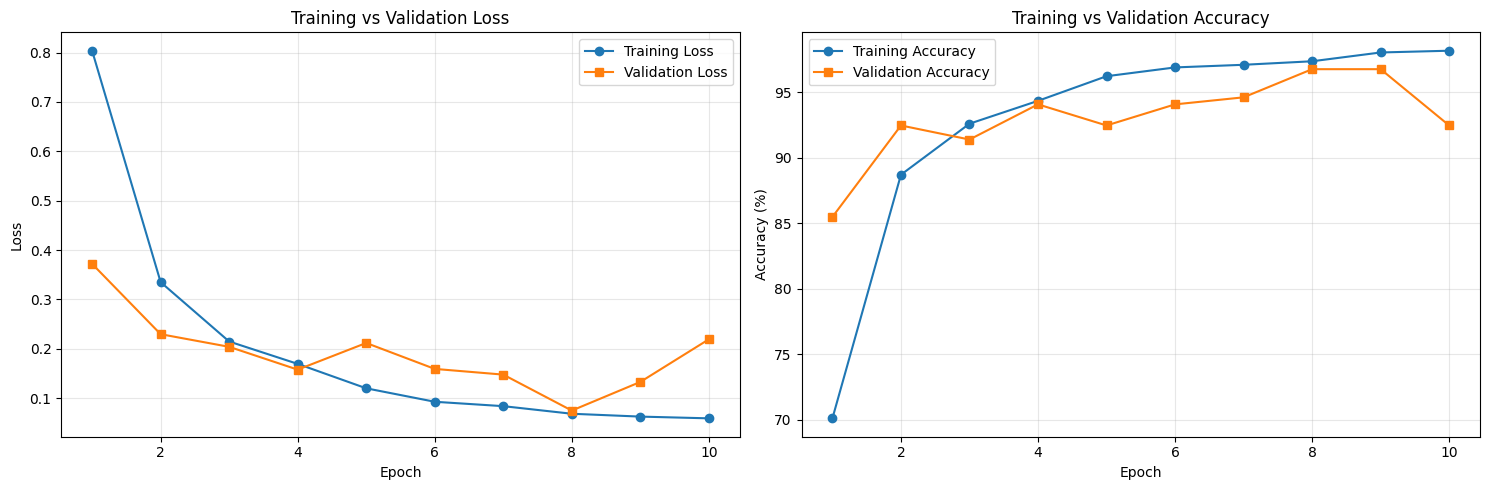

In [24]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(train_losses) + 1)

# Plot losses
ax1.plot(epochs, train_losses, label="Training Loss", marker='o')
ax1.plot(epochs, val_losses, label="Validation Loss", marker='s')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Validation Loss")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
ax2.plot(epochs, val_accuracies, label="Validation Accuracy", marker='s')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("Training vs Validation Accuracy")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Confusion Matrix:
[[20  0  0  1  1]
 [ 0 52  0  0  0]
 [ 0  1 30  0  2]
 [ 0  0  0 47  0]
 [ 4  0  0  0 28]]
Classification Report:
              precision    recall  f1-score   support

         Lab       0.83      0.91      0.87        22
        Tree       0.98      1.00      0.99        52
    building       1.00      0.91      0.95        33
         car       0.98      1.00      0.99        47
      person       0.90      0.88      0.89        32

    accuracy                           0.95       186
   macro avg       0.94      0.94      0.94       186
weighted avg       0.95      0.95      0.95       186

